In [73]:
import json
import threading
import numpy as np
from typing import List, Set
from math import inf, sqrt, floor
import pandas as pd
import shutil
from pathlib import Path
import re
import matplotlib.pyplot as plt

In [55]:
class nsgaii_var:
    id = 0
    idlock = threading.Lock()

    def __init__(self, optvar) -> None:

        self.optvar = np.array(optvar)  ###varaiables For optim
        self.simvar = None  ###varaiables for simulation
        self.rank = 0
        self.rawobj = (
            None  # Save all mid and final values for record (self.output+self.mid)
        )
        self.obj = None  # Save Objective transformed for minimum search (self.obj)
        self.pset: Set[nsgaii_var] = (
            set()
        )  ### set of var domed by p ### By Ref so it might be memory safe
        self.done = False
        self.sorted = False
        self.n = 0
        self.crowed_dis = 0
        self.crowed_dis_calc_done = False
        self.constrainted_obj = None
        self.constraint_violaton_value = 0
        self.id = nsgaii_var._getNewAvailableId()

    @classmethod
    def _getNewAvailableId(cls):
        cls.idlock.acquire()
        cls.id += 1
        cls.idlock.release()
        return cls.id

    @classmethod
    def _setMinAvailableId(cls, minid):
        cls.idlock.acquire()
        cls.id = minid
        cls.idlock.release()
        return cls.id

    def duplicate(self) -> "nsgaii_var":
        #### Get An Unsorted Var Duplicate
        dup = nsgaii_var(self.optvar)
        dup.obj = self.obj.copy()
        return dup

    def setRawObjs(self, rawobjective):
        self.rawobj = np.array(rawobjective)

    def setObjs(self, objective):
        self.obj = np.array(objective)

    def setConstrainted_objs(self, c_objective):
        self.constrainted_obj = np.array(c_objective)

    def setSimVar(self, simvar):
        self.simvar = np.array(simvar)

    def dom(self, other):
        ### FIND MINIMUM
        tarray = np.less(self.obj, other.obj)
        earray = np.less_equal(self.obj, other.obj)
        if np.all(earray) and np.any(tarray):
            return True  ### A N Domi B
        else:
            return False

    def constrainted_dom(self, other):
        if self.constraint_violaton_value < other.constraint_violaton_value:
            return True
        elif self.constraint_violaton_value > other.constraint_violaton_value:
            return False
        else:
            return self.dom(other)

    def crowed_cmp_lt(self, other):
        if self.rank < other.rank:
            return True
        elif self.rank == other.rank:
            if self.crowed_dis > other.crowed_dis:
                return True
        return False

    def crowed_cmp_gt(self, other):
        if self.rank > other.rank:
            return True
        elif self.rank == other.rank:
            if self.crowed_dis < other.crowed_dis:
                return True
        return False

    def crowed_cmp_eq(self, other):
        if self.rank == other.rank and self.crowed_dis == other.crowed_dis:
            return True
        else:
            return False

    def __str__(self):
        # idict={"id":self.id,"Rank":self.rank,"N":self.n}
        idict = {"id": self.id,"Rank":self.rank,"crowd_distance":self.crowed_dis}
        str = json.dumps(idict, indent=4)
        return str

    def __repr__(self) -> str:
        str = "nsgaii_var obj:" + self.__str__()
        return str

    def __eq__(self, __o: object) -> bool:
        if self.id != __o.id:
            return False
        return True

    def __hash__(self):
        return hash(self.id)

In [9]:
def fnds(self, poplist: List[nsgaii_var]):  ## Fast non dominated sort

        flist: List[List[nsgaii_var]] = [None for _ in range(len(poplist))]
        flist[0] = list()

        #### reset relations
        for i in poplist:
            i.pset.clear()
            i.n = 0
        #### Get All Dom Relations
        for p in poplist:
            for q in poplist:
                if p.id == q.id:
                    continue

                if not self.constrainted:  ####Type 1 支配排序
                    if p.dom(q):
                        p.pset.add(q)  ### I DOM YOU
                    elif q.dom(p):
                        p.n += 1  ## Be Domed count
                else:
                    if p.constrainted_dom(q):
                        p.pset.add(q)  ### I DOM YOU
                    elif q.constrainted_dom(p):
                        p.n += 1  ## Be Domed count

            if p.n == 0:  ## not domed By Anyone
                p.rank = 0  ### first front
                flist[0].append(p)

        #### Sort
        i = 0

        while len(flist[i]) > 0:
            # print([str(p.n) for p in vallist])
            q_set = set()
            for p in flist[i]:

                for q in p.pset:
                    q.n -= 1  ### 除p外q仍被支配的个数
                    if q.n == 0:  ### not domed By Anyone Except P
                        q.rank = i + 1
                        q_set.add(q)

            i += 1
            if i >= len(flist):
                break
            flist[i] = list(q_set)

        return flist

In [50]:
def crowding_dis_assign(
        nobj,
        flist: List[nsgaii_var],
    ):  # sort vars by the distance of objectives

        if len(flist) == 0:
            return
        elif len(flist) <= 2:
            for var in flist:
                var.crowed_dis = inf
                var.crowed_dis_calc_done = True
            return
        for i in range(nobj):
            ilist = sorted(flist, key=lambda x: x.obj[i])
            ilist[0].crowed_dis = inf
            ilist[0].crowed_dis_calc_done = True
            ilist[-1].crowed_dis = inf
            ilist[-1].crowed_dis_calc_done = True
            coff = ilist[-1].obj[i] - ilist[0].obj[i]
            for u in range(len(ilist)):
                if not ilist[u].crowed_dis_calc_done:
                    if ilist[u + 1].obj[i] == ilist[u - 1].obj[i]:
                        ilist[u].crowed_dis += 0
                    else:
                        ilist[u].crowed_dis += (
                            ilist[u + 1].obj[i] - ilist[u - 1].obj[i]
                        ) / coff

In [ ]:
def load_dumped_pop(self):
        ####search avilable save
        savedir = self.manager.resultDir
        files = savedir.glob("GEN_*_Population.json")
        if sum(1 for x in files) == 0:
            return None

        files = savedir.glob("GEN_*_Population.json")
        maxigen = 0
        vaild = re.compile(r"GEN_(\d+)_Population.json")
        for file in files:
            igen = int(vaild.search(file.name)[1])
            if igen > maxigen:
                maxigen = igen
        igen = maxigen
        #### Remove corrupted data
        vaild2 = re.compile(r"GEN_(\d+)")
        files = savedir.glob("GEN_*")
        for file in files:
            tgen = int(vaild2.search(file.name)[1])
            if tgen > igen:
                if file.is_dir():
                    shutil.rmtree(file)
                else:
                    file.unlink()
                self.logger.warning("Data file:%s from last run removed." % file.name)
        ####Done
        fp = open(savedir / ("GEN_%d_Population.json" % igen), "r")
        saved = json.load(fp)
        fp.close()

        unsorted_poplist = []
        for _key, value in saved.items():
            nv = nsgaii_var(value["optvar"])
            nv.id = int(value["id"])
            nv.rank = 0
            nv.setSimVar(value["simvar"])
            nv.setRawObjs(value["rawobj"])
            nv.setObjs(value["obj"])
            nv.setConstrainted_objs(value["constrainted_obj"])
            nv.constraint_violaton_value = value["constraint_violaton_value"]
            unsorted_poplist.append(nv)
        population = {"igen": igen, "poplist": unsorted_poplist}
        fp = open(savedir / ("GEN_%d_Info.json" % igen), "r")
        minid = json.load(fp).get("current_min_id", 0)
        self.logger.info("current_min_id:%d." % minid)
        nsgaii_var._setMinAvailableId(minid)
        return population

In [81]:
def load_csv(csvpath):
    input_name_sim = [
            "C2",
            "C3",
            "C4",
            "d1x",
            "d2x",
            "d2y",
            "g",
            "L0",
        ]
    object_name = [  ### target name
            "frequency_offset",
            "Epk@2MV",
            "Shunt_Inpedence",
        ]
    constrainted_object_name = ["Frequency (Mode 1)"]
    df=pd.read_csv(csvpath)
    unsorted_poplist = []

    
    # print(df[df['Front Index']<1].iloc[0])
    totalitens=len(df[df['Front Index']<1])
    #print(totalitens)
    # query=df[df['Front Index']<1].iloc[0]
    # ptv=query[object_name]
    # print(ptv.to_list())
    for i in range(totalitens):
        query=df[df['Front Index']<1].iloc[i]
        optv=query[object_name].to_list()
        nv = nsgaii_var(optv)
        nv.id = int(query["Index"])
        nv.rank = 0
        simvar=query[input_name_sim].to_list()
        nv.setSimVar(simvar)
        nv.setRawObjs(optv)
        nv.setObjs(optv)
        co=query[constrainted_object_name].to_list()
        nv.setConstrainted_objs(co)
        nv.constraint_violaton_value = float(query["constraint_value"])
        unsorted_poplist.append(nv)
    crowding_dis_assign(3,unsorted_poplist)
    
    crowdlist=[item.crowed_dis for item in unsorted_poplist]
    filtered=[]
    for item in crowdlist:
        if item != inf:
            filtered.append(item)
    if len(filtered) ==0:
        return unsorted_poplist,None
    maxc=np.max(filtered)
    minc=np.min(filtered)
    avgc=np.mean(filtered)
    stat={
        "maxc":maxc,
        "minc":minc,
        "avgc":avgc
    }
    return unsorted_poplist,stat
    

In [ ]:
def process():
    csvpathstr=r"F:\Project\WTC\NEW\NEW400ResultProcessed\GEN_%d_Individuals_accept.csv"
    maxcl=[]
    mincl=[]
    avgcl=[]
    xs=[]
    for i in range(70):
        _,stat=load_csv(Path(csvpathstr % i))
        if stat is None:
            continue
        xs.append(i)
        maxcl.append(stat["maxc"])
        mincl.append(stat["minc"])
        avgcl.append(stat["avgc"])
        
    plt.plot(xs,maxcl)
    plt.plot(xs,mincl)
    plt.plot(xs,avgcl)
    plt.show()
    return xs,maxcl,avgcl,mincl

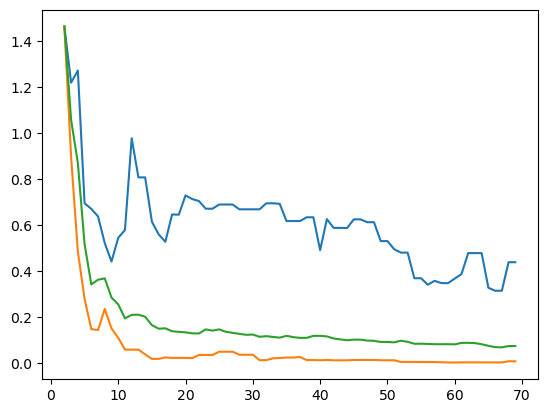

In [86]:
xs,maxcl,avgcl,mincl=process()


In [87]:
result=pd.DataFrame(list(zip(xs,maxcl,avgcl,mincl)),columns=["generation","max distance","avg distance","min distance"])
result.to_csv(r"F:\Project\WTC\NEW\NEW400ResultProcessed\Distances.csv")